<a href="https://colab.research.google.com/github/mansimar11/Asteroid_Spectra_ml_dl/blob/main/dl_dense_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing

In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Mounted at /gdrive


In [3]:
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [5]:
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
print(asteroids_oh_y[0])

[1. 0. 0. 0.]


In [7]:
# OK how are things encoded?
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [8]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [9]:
# We need to create weights for our samples. Similar like the class weights, but here, our classes
# are one-hot encoded. Sample weights are easier to handle!
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [ ]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    # Normalizsation layer (like the scikit-learn StandardScaler)
    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs,))

    hidden_layer = normalizer(input_layer)

    hidden_layer = keras.layers.Dense(25)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    hidden_layer = keras.layers.Dense(10)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    sample_weight=sample_weight)

In [11]:
# Please note, online tutorials show mostly "default" batch sizes, like 32, 64, etc. But take a
# look at the size of the last batch. It does not correspond to the batch size itself! Be aware of
# these things
print(f"'Last' batch size: {len(X_train) % batch_size}")

'Last' batch size: 15


Text(0, 0.5, 'Loss')

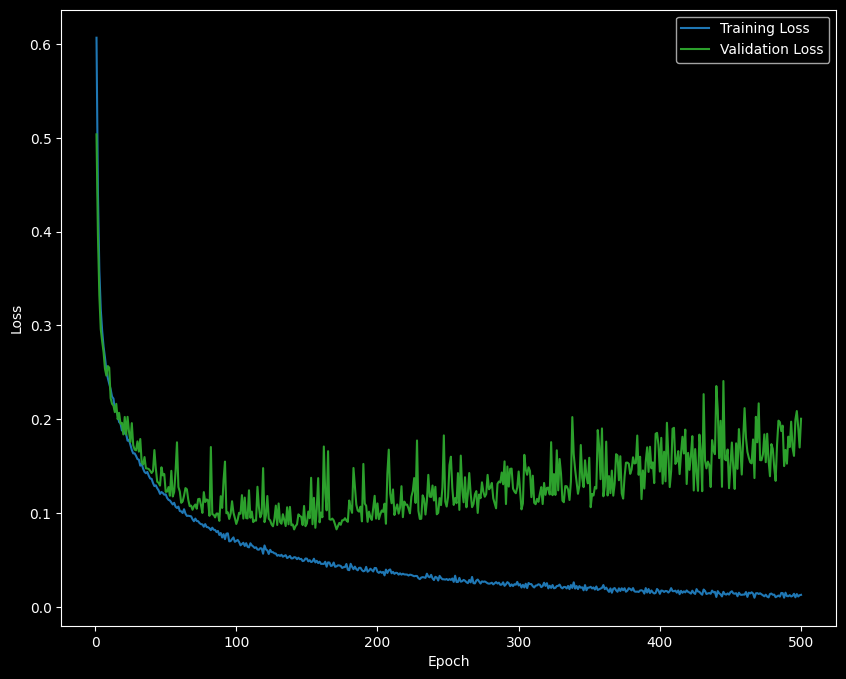

In [12]:
# Let's plot the losses
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

In [14]:
y_test_prop_pred = model.predict(X_test)
print(y_test_prop_pred)

9/9 [==============================] - 0s 2ms/step
[[3.8219124e-08 1.3744663e-02 9.8624003e-01 1.5152155e-05]
 [5.3055334e-07 3.2280732e-02 9.6758860e-01 1.3009169e-04]
 [4.6209111e-06 2.8707467e-02 1.2863958e-06 9.7128659e-01]
 ...
 [6.0157848e-09 4.8488784e-01 5.1223963e-01 2.8725653e-03]
 [3.0200235e-12 9.2317837e-01 7.6717556e-02 1.0409043e-04]
 [8.3440847e-07 2.2336999e-01 7.6606524e-01 1.0563915e-02]]


In [15]:
# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1
print(y_test_oh_pred)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [16]:
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

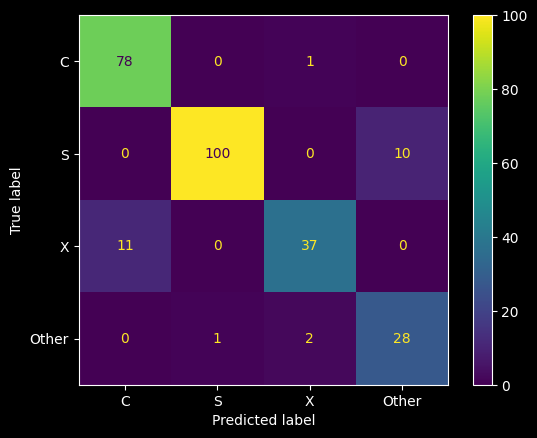

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [18]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test, asteroid_classes_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.907


In [19]:
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [20]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [21]:
asteroids_X = np.expand_dims(asteroids_X, axis=2)

In [22]:
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

# OK how are things encoded?
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [24]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [25]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    norm_layer = normalizer(input_layer)

    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3)(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Conv1D(filters=64,
                                       activation="relu",
                                       kernel_size=5)(hidden_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Flatten()(hidden_layer)
    hidden_layer = keras.layers.Dense(16, activation="relu")(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 normalization_2 (Normaliza  (None, 49, 1)             99        
 tion)                                                           
                                                                 
 conv1d (Conv1D)             (None, 47, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 64)             0   

In [26]:
end_epoch = 400
batch_size = 64

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    sample_weight=sample_weight)

Text(0, 0.5, 'Loss')

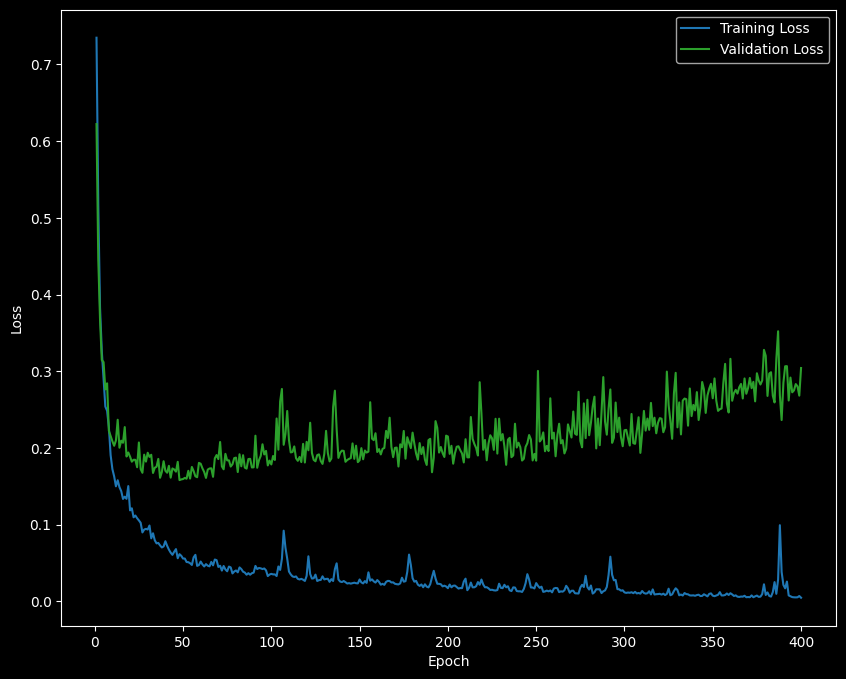

In [27]:
# Let's plot the losses
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# Let's train
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

In [29]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

9/9 [==============================] - 0s 5ms/step


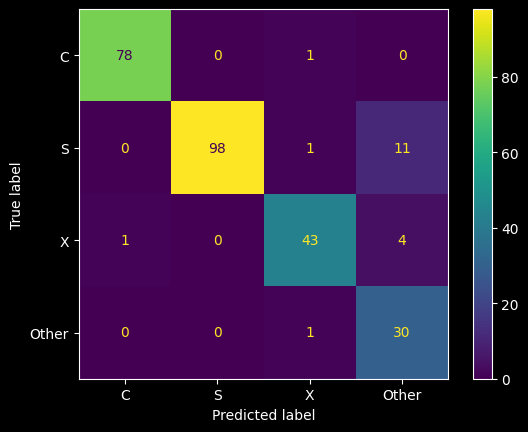

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [31]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test,
                                          asteroid_classes_test_pred,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.933
